In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

In [2]:
data = pd.read_csv("../data/deep-scenario.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33530 entries, 0 to 33529
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Execution                      33530 non-null  int64  
 1   ScenarioID                     33530 non-null  object 
 2   Configuration_API_Description  33530 non-null  object 
 3   Attribute[TTC]                 33530 non-null  float64
 4   Attribute[DTO]                 33530 non-null  float64
 5   Attribute[Jerk]                33530 non-null  float64
 6   Attribute[COL]                 33530 non-null  bool   
 7   Attribute[COLT]                33530 non-null  object 
 8   Attribute[SAC]                 33530 non-null  float64
 9   reward                         33530 non-null  object 
 10  road                           33530 non-null  object 
 11  strategy                       33530 non-null  object 
 12  scenario                       33530 non-null 

In [4]:
class DataManipulation():
    def __init__(self, filename: str=""):
        self.data = filename


    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, filename: str=""):
        try:
            self._data = pd.read_csv(filename)
        except:
            self._data = None
            raise FileNotFoundError(f"The file does not exist.")


    def addFromXML(self, filename: str="") -> None:
        """
        Reads more data from XML files, as of now, only speeds at six different timstamps.

        Params:
            filename: str, name of file read from
        """
        try:
            xmlDf = pd.read_csv(filename, index_col=0)
        except:
            raise FileNotFoundError(f"The file does not exist.")
        if isinstance(self.data, pd.DataFrame):
            self._data = self.data.merge(xmlDf, how="inner", on=["ScenarioID", "road", "reward", "scenario", "strategy"], copy=False)
        else:
            print("Something went wrong in 'addFromXML()'!")


    def splitTrainTest(self, splitRatio: float=0.8) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Splitting the data.

        Params:
            filename: str, name of file to split
            splitRatio: float 0-1, % of data to be testing

        TODO
            Slå sammen road, scenario, strategy og reward til noe brukbart

        Returns:
            trainX, trainY, testingX, testingY.
        """
        if not 0 < splitRatio < 1: raise ValueError("SplitRatio must be between 0 and 1!")

        # Shuffle data
        self._data = self.data.sample(frac=1, random_state=1)

        temp = self._data.copy()
        # Removing all non numeric values, might need to make string values into numbers
        temp = temp.drop(["Execution","ScenarioID","Configuration_API_Description"], axis=1)
        split = int(np.floor(len(self.data)*splitRatio))
        print(f"splitting at {split}.")

        trainX, testX = temp[:split], temp[split:]

        trainY = pd.concat([trainX.pop(feature) for feature in ["Attribute[COL]","Attribute[COLT]","Attribute[SAC]"]], axis=1)
        testY = pd.concat([testX.pop(feature) for feature in ["Attribute[COL]","Attribute[COLT]","Attribute[SAC]"]], axis=1)

        return trainX, trainY, testX, testY


    def getCompleteRow(self, index: None):
        """
        Gets the origianl row from index(es).

        Params:
            index: int or list

        Return:
            Dataframe or Series
        """
        if isinstance(index, list) or isinstance(index, int):
            return self._data.loc[index]
        return "Something went wrong."


    def getOriginalPath(self, index: int):
        """
        Gets the complete path from where the row was originally collected together with its ScenarioID.

        Params:
            index: int

        Return:
            dict{"SenarioID": str, "path": str}
        """
        if isinstance(index, int):
            row = self.getCompleteRow(index)
            return {
                "ScenarioID": row["ScenarioID"],
                "path": f"{row['strategy']}-strategy/reward-{row['reward']}/{row['road']}-{row['scenario']}-scenario-attributes.csv"
                }
        raise ValueError("Index needs to be an integer!")


In [12]:
dm = DataManipulation("../data/deep-scenario.csv")
dm.addFromXML("../data/dataFromXML.csv")

trainX, trainY, testX, testY = dm.splitTrainTest()
print(f"trainX:{trainX.shape}, trainY:{trainY.shape}, testX:{testX.shape}, testY:{testY.shape}")

print(trainX.head())

d = pd.concat([trainX, trainY], axis=1)
df = d.groupby(['strategy', 'Attribute[COL]']).size()
df = df.unstack()
df

splitting at 26824.
trainX:(26824, 13), trainY:(26824, 3), testX:(6706, 13), testY:(6706, 3)
       Attribute[TTC]  Attribute[DTO]  Attribute[Jerk] reward   road  \
23853   100000.000000        6.434714             5.04    ttc  road2   
30032        0.695324        5.552715             5.74   jerk  road2   
11507   100000.000000        8.511993             5.90    ttc  road3   
17653        0.760641        7.845926            14.30    dto  road4   
16680        8.738029       14.960495             0.88    dto  road3   

       strategy     scenario  speed1  speed2  speed3  speed4  speed5  speed6  
23853    random   rain_night   5.547   4.660   4.401   4.228   3.986   3.746  
30032  rl_based  sunny_night   5.558   4.607   4.358   4.832   4.246   3.967  
11507    greedy   rain_night   0.908   0.001   0.789   0.687   0.001   1.000  
17653    random  sunny_night   5.127   6.324   6.615   8.165   8.313   8.683  
16680    random  sunny_night   8.075   8.280   8.360   8.458   8.566   8.755  


Attribute[COL],False,True
strategy,,
greedy,10440,147
random,10736,129
rl_based,4813,559


In [13]:
d.corr()

C:\Users\Yohannes\AppData\Local\Temp/ipykernel_8764/2319908662.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  d.corr()


,Attribute[TTC],Attribute[DTO],Attribute[Jerk],speed1,speed2,speed3,speed4,speed5,speed6,Attribute[COL],Attribute[SAC]
Attribute[TTC],1.000000,0.100788,-0.144095,-0.253022,-0.240292,-0.193335,-0.147007,-0.108904,-0.084859,-0.047727,-0.048451
Attribute[DTO],0.100788,1.000000,-0.036130,-0.079110,-0.064905,-0.033969,-0.004660,0.017686,0.032633,-0.011135,-0.008658
Attribute[Jerk],-0.144095,-0.036130,1.000000,0.220794,0.207929,0.138693,0.079876,0.040943,0.017524,0.099308,0.095497
speed1,-0.253022,-0.079110,0.220794,1.000000,0.965072,0.873227,0.747700,0.635589,0.548470,0.113364,0.108645
speed2,-0.240292,-0.064905,0.207929,0.965072,1.000000,0.930704,0.817816,0.714630,0.633528,0.093444,0.090953
speed3,-0.193335,-0.033969,0.138693,0.873227,0.930704,1.000000,0.935293,0.853828,0.778939,0.033763,0.077092
speed4,-0.147007,-0.004660,0.079876,0.747700,0.817816,0.935293,1.000000,0.950989,0.888524,-0.041214,0.052189
speed5,-0.108904,0.017686,0.040943,0.635589,0.714630,0.853828,0.950989,1.000000,0.960588,-0.101034,0.006146
speed6,-0.084859,0.032633,0.017524,0.548470,0.633528,0.778939,0.888524,0.960588,1.000000,-0.132265,-0.024836
Attribute[COL],-0.047727,-0.011135,0.099308,0.113364,0.093444,0.033763,-0.041214,-0.101034,-0.132265,1.000000,0.776937


In [19]:
class Predicter():
    """
    NOTE: Should try other models and should do something about TTC, some are < 15, many are 100000.
    """
    def __init__(self):
        self.model = MLPClassifier(solver="adam")


    def preProcess(self, x=None, y=None, targetCol="Attribute[COL]"):
        """
        Process x and y by transforming to np.array and mean scale x.
        
        Params:
            x: dataframe
            y: dataframe
            targetCol: str, name of column that is to be predicted
        
        Returns:
            x: np.array
            y: np.array
        """

        if isinstance(x, pd.DataFrame):

            # label encode road and scenario
            x = self.labelEncode(x)

            # only accepts numeric values in training as of now
            for c in x.columns:
                if x[c].dtype != float:
                    x = x.drop(c, axis=1)
            x.loc[x["Attribute[TTC]"]==100000, "Attribute[TTC]"] = -1 # NOTE May be transformed to something else
            x.loc[x["Attribute[DTO]"]==100000, "Attribute[DTO]"] = -1
            # print(x.columns)
            x = x.to_numpy()
            scaler = preprocessing.StandardScaler().fit(x) # Scaling the input
            x = scaler.transform(x)

        if isinstance(y, pd.DataFrame):
            if targetCol and targetCol in y.columns:
                y = y[targetCol]
                y.replace(False, 0, inplace=True)
                y.replace(True, 1, inplace=True)
                y = y.to_numpy()
            else:
                print("Wrong parameters was sent in!")
        
        return x, y

    def labelEncode(self, x: pd.DataFrame, cols: list[str] = ["road", "scenario"]):
        """
        Label encoding for cols, default is road and scenario.

        Params:
            x: Dataframe
            cols: list of str, columns to label encode

        Returns:
            x: Dataframe
        """
        x[cols] = x[cols].apply(preprocessing.LabelEncoder().fit_transform)
        return x
        
        

    def fit(self, x, y):
        """
        Train the model.

        Params:
            x: np.array, preprocessed training data
            y: np.array, preprocessed training truth
        """
        self.model.fit(x, y)


    def predict(self, x):
        """
        Params:
            x: Dataframe, what to predict

        Returns:
            predictions: np.array of 0 and 1
        """
        return self.model.predict(x)


    def getScore(self, predictions, truth):
        """"
        Shows the score of given predictions and ground truth in a confusion matrix.
        
        Prints as follows:
            True negative | False positive

            False negative | True positive

        Params:
            predictions: np.array
            truth: np.array
        
        Returns:
            cm: list[list]
        """
        _, truthProcessed = self.preProcess(y=truth)
        tot = 0
        cm = [[0, 0], [0, 0]]
        col = np.count_nonzero(truthProcessed == 1)
        
        for p, t in zip(predictions, truthProcessed):
            cm[t][p] += 1
            tot += 1

        prec = cm[1][1]/(cm[0][1]+cm[1][1])
        rec = cm[1][1]/(cm[1][1]+cm[1][0])
        print(f"Total: {tot}, number of collisions: {col}")
        print(f"\tTN: {cm[0][0]} \t| FP: {cm[0][1]} \n\tFN: {cm[1][0]} \t| TP: {cm[1][1]}")
        print(f"Accuracy: {round((cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]), 2)}")
        print(f"Precision: {round(prec, 2)}")
        print(f"Recall: {round(rec, 2)}")
        print(f"F1: {round(2*prec*rec/(prec+rec), 2)}")
        return cm

In [22]:
p = Predicter()

x, y = p.preProcess(trainX, trainY)
p.fit(x, y)

testXp, testYp = p.preProcess(testX, testY)
pred = p.predict(testXp)
score = p.getScore(pred, testYp)


Total: 6706, number of collisions: 215
	TN: 6480 	| FP: 11 
	FN: 106 	| TP: 109
Accuracy: 0.98
Precision: 0.91
Recall: 0.51
F1: 0.65


Attribute[TTC] -0.1578840050542386 90.90024719090034


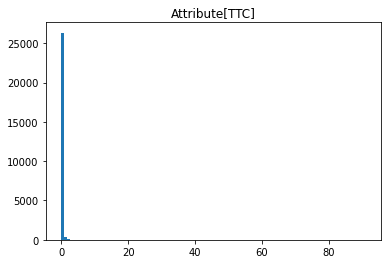

Attribute[DTO] -1.256719574816438 6.641942818424161


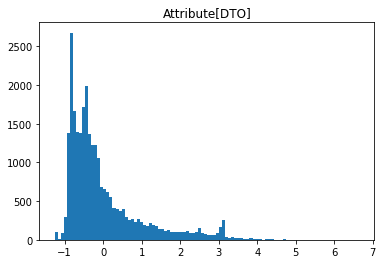

Attribute[Jerk] -1.544001742140213 3.9944385816461385


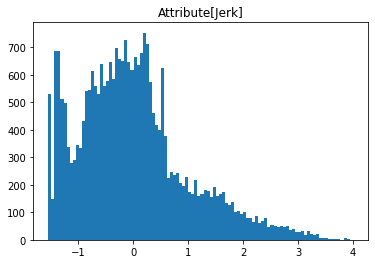

speed1 -1.5385288359310705 4.0423792594104055


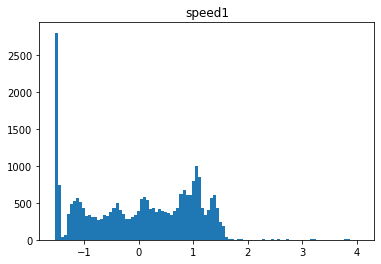

speed2 -1.5773083889854247 3.947382470593386


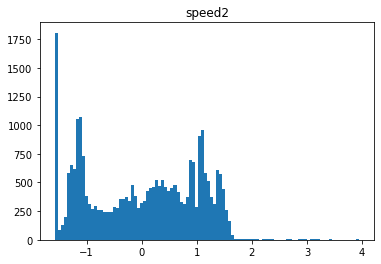

speed3 -1.6952482523370034 4.12356054540394


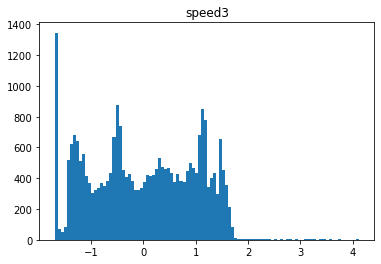

speed4 -1.7046654235044822 4.207266079210908


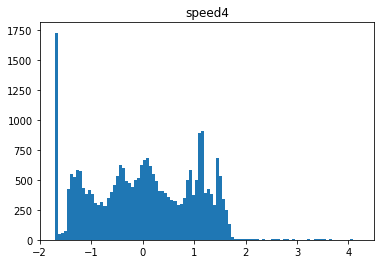

speed5 -1.6744918236671043 4.079085066106205


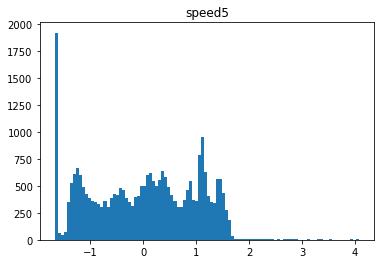

speed6 -1.624826311944873 4.003446469514049


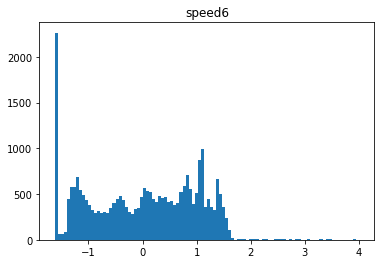

In [24]:
def his(column, name):
    plt.hist(column, bins=100)
    plt.title(name)
    plt.show()

names = ['Attribute[TTC]', 'Attribute[DTO]', 'Attribute[Jerk]', 'speed1', 'speed2', 'speed3', 'speed4', 'speed5', 'speed6']
for i in range(len(x[0,:])):
    print(names[i], min(x[:,i]), max(x[:,i]))
    his(x[:,i], names[i])
    